# LAB: Multimodal Learning WSI + Genomics
Authors:
- Vittorio Pipoli (vittorio.pipoli@unimore.it)
- Francesca Miccolis (francesca.miccolis@unimore.it)

### Assignment Goals
1. Familiarity with the “Survival Prediction from WSI and Genomics” task
2. Familiarity with multimodal architectures
3. Implementation of a customised model for “Survival Prediction from WSI and Genomics”

### References
1. ABMIL (paper: https://proceedings.mlr.press/v80/ilse18a/ilse18a.pdf)
3. MCAT (paper: https://openaccess.thecvf.com/content/ICCV2021/papers/Chen_Multimodal_Co-Attention_Transformer_for_Survival_Prediction_in_Gigapixel_Whole_Slide_ICCV_2021_paper.pdf)
2. SurvPath (paper: https://openaccess.thecvf.com/content/CVPR2024/papers/Jaume_Modeling_Dense_Multimodal_Interactions_Between_Biological_Pathways_and_Histology_for_CVPR_2024_paper.pdf)

### install missing packages

In [1]:
!pip install pytorch_model_summary
!pip install munch
!pip install scikit-survival
!pip install lifelines

### import packages

In [2]:
import os
import torch
from torch import nn
import torch.optim as optim
from torch.backends import cudnn
import torch.nn.init as init
from pytorch_model_summary import summary
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
import time
import logging
from tqdm import tqdm
import math
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from munch import Munch
from sksurv.metrics import concordance_index_censored
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from lifelines import KaplanMeierFitter
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score
import random
from lifelines.statistics import logrank_test

In [3]:
def setup(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # If using CUDA.
    torch.cuda.manual_seed_all(seed)  # If using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
### Fix random seed for reproducibility (Try different random seeds)
SEED = 42
setup(SEED)

# Download Multimodal Survival Dataset (TCGA BRCA)

### downaload takes approx. 10 to 20 minutes...

In [4]:
'''
# Choose one of the two and comment the other one.
# OneDrive seems to be the faster.

# Download from UNIMORE
# !wget https://ailb-web.ing.unimore.it/publicfiles/AIforBio/small/LAB_WSI_Genomics.zip

# Download from OneDrive
!wget -O LAB_WSI_Genomics.zip "https://unimore365-my.sharepoint.com/:u:/g/personal/vpipoli_unimore_it/EZakt73hnBJGng4OCqCpFaQBULa4HU5FCz8aNxE-0z87_w?e=tvB5ep&download=1"

'''

'\n# Choose one of the two and comment the other one.\n# OneDrive seems to be the faster.\n\n# Download from UNIMORE\n# !wget https://ailb-web.ing.unimore.it/publicfiles/AIforBio/small/LAB_WSI_Genomics.zip\n\n# Download from OneDrive\n!wget -O LAB_WSI_Genomics.zip "https://unimore365-my.sharepoint.com/:u:/g/personal/vpipoli_unimore_it/EZakt73hnBJGng4OCqCpFaQBULa4HU5FCz8aNxE-0z87_w?e=tvB5ep&download=1"\n\n'

In [5]:
'''
!wget -O LAB_WSI_Genomics.zip "https://unimore365-my.sharepoint.com/:u:/g/personal/vpipoli_unimore_it/EZakt73hnBJGng4OCqCpFaQBULa4HU5FCz8aNxE-0z87_w?e=tvB5ep&download=1"
'''

'\n!wget -O LAB_WSI_Genomics.zip "https://unimore365-my.sharepoint.com/:u:/g/personal/vpipoli_unimore_it/EZakt73hnBJGng4OCqCpFaQBULa4HU5FCz8aNxE-0z87_w?e=tvB5ep&download=1"\n'

### unzip files...

In [6]:
'''
!unzip LAB_WSI_Genomics
'''

'\n!unzip LAB_WSI_Genomics\n'

### Multimodal Survival Dataset Class

In [7]:

TCGA_BRCA_dataset_config = {
    "name": "TCGA_BRCA",
    "parameters": {
        "dataframe_path": "G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/TCGA_BRCA_labels_multimodal.tsv",
        "pt_files_path": "G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/Data/wsi/features_UNI/pt_files",
        "genomics_path": "G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/Data/genomic/tpm_unstranded.csv",
        "tissue_type_filter": [],
        "label_name": "FUT",
        "censorships_name": "Survival",
        "case_id_name": "case_id",
        "slide_id_name": "slide_id",
    }
}
TCGA_BRCA_dataset_config = Munch.fromDict(TCGA_BRCA_dataset_config)

### inspect genomic data

In [8]:
genomics = pd.read_csv("G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/Data/genomic/fpkm_uq_unstranded.csv", sep="\t")
genomics = genomics.set_index("Unnamed: 0").dropna()
genomics

,ENSG00000000003.15,ENSG00000000005.6,ENSG00000000419.13,ENSG00000000457.14,ENSG00000000460.17,ENSG00000000938.13,ENSG00000000971.16,ENSG00000001036.14,ENSG00000001084.13,ENSG00000001167.14,...,ENSG00000288649.1,ENSG00000288654.1,ENSG00000288656.1,ENSG00000288658.1,ENSG00000288660.1,ENSG00000288661.1,ENSG00000288669.1,ENSG00000288671.1,ENSG00000288674.1,ENSG00000288675.1
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
TCGA-5L-AAT0,18.8059,0.1004,22.5429,2.9239,1.2015,3.2076,6.4220,11.5534,2.7377,11.2851,...,0.0,0.0,0.0000,0.0100,0.0408,0.0,0.0000,0.0,0.0154,0.1764
TCGA-A2-A04U,28.1036,0.3642,81.6555,1.9173,1.0850,1.1046,2.0680,12.8385,2.3671,14.9513,...,0.0,0.0,0.0000,1.2410,0.0000,0.0,0.0000,0.0,0.0363,0.1440
TCGA-A7-A13D,11.1499,0.0185,44.3259,2.9034,4.6663,1.2610,5.3923,13.8049,2.4426,17.0157,...,0.0,0.0,0.0000,0.0921,0.0000,0.0,0.0000,0.0,0.0142,0.0000
TCGA-BH-A201,11.9087,0.3088,31.9381,4.1172,2.2652,3.1944,8.2867,11.7111,4.3585,15.1350,...,0.0,0.0,0.0000,0.0410,0.0000,0.0,0.0000,0.0,0.0174,0.2532
TCGA-BH-A0H6,24.3593,0.3923,24.9951,2.6949,1.0033,1.4877,3.9207,16.9523,6.8670,12.9826,...,0.0,0.0,0.0051,0.0135,0.1373,0.0,0.0000,0.0,0.0145,0.1902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-A8-A07O,11.5273,0.0095,32.9329,4.1108,5.8366,2.2484,2.9732,9.1498,5.0707,16.4606,...,0.0,0.0,0.0000,0.5590,0.0193,0.0,0.0000,0.0,0.0117,0.1004
TCGA-A2-A1FV,6.8917,0.7166,22.6665,9.9951,3.1676,0.8495,5.2142,11.9031,4.8050,19.4060,...,0.0,0.0,0.0183,0.0193,0.0000,0.0,0.0072,0.0,0.0119,0.2382
TCGA-C8-A275,9.0502,0.0975,35.7034,8.4364,3.4478,7.8937,8.9764,13.0280,3.8271,13.8441,...,0.0,0.0,0.0037,0.0291,0.0000,0.0,0.0000,0.0,0.0060,0.0856


### inspect main dataframe

In [9]:
dataframe = pd.read_csv("G:/Il mio Drive/datasets/LAB_WSI_Genomics/TCGA_BRCA/TCGA_BRCA_labels_multimodal.tsv", sep="\t")
dataframe = dataframe.dropna()
dataframe


,case_id,slide_id,True_Label,FUT,Survival
0,TCGA-C8-A1HO,TCGA-C8-A1HO-01A-01-TSA.5331126c-9810-4054-902...,Alive,375.0,1
1,TCGA-AQ-A0Y5,TCGA-AQ-A0Y5-01A-01-MSA.e8612b52-6969-4d03-aa7...,Dead,172.0,0
2,TCGA-EW-A2FW,TCGA-EW-A2FW-01A-01-TSA.93F3FA5A-4797-489A-B86...,Alive,672.0,1
3,TCGA-C8-A1HI,TCGA-C8-A1HI-01Z-00-DX1.C6D0F8B8-55ED-477F-BAF...,Alive,343.0,1
4,TCGA-AR-A2LL,TCGA-AR-A2LL-01A-01-TSA.DB96FA2A-150F-4387-9F4...,Alive,2012.0,1
...,...,...,...,...,...
1054,TCGA-LL-A6FP,TCGA-LL-A6FP-01A-01-TS1.E618EA84-C425-4B27-BCC...,Alive,0.0,1
1055,TCGA-5L-AAT1,TCGA-5L-AAT1-01A-01-TS1.140261A5-268A-4C22-9E3...,Alive,1471.0,1
1056,TCGA-AR-A2LR,TCGA-AR-A2LR-01A-01-TSA.E8716040-4787-4C4B-903...,Alive,1742.0,1
1057,TCGA-A8-A06U,TCGA-A8-A06U-01A-01-BS1.1182603b-20e7-4a0e-a68...,Dead,883.0,0


In [28]:
dataframe["Survival"].value_counts()

Survival
1    912
0    146
Name: count, dtype: int64

In [10]:
has_dups = dataframe['case_id'].duplicated().any()
print(has_dups)  # True se esiste almeno un duplicato


False


In [11]:
class Multimodal_WSI_Genomic_Dataset(Dataset):
    def __init__(self,  datasets_configs = [TCGA_BRCA_dataset_config],
                        task_type="Survival", # Survival or treatment_response
                        max_patches=4096,
                        n_bins=4,
                        eps=1e-6,
                        sample=True,
                        load_slides_in_RAM=False,
                        ):
        self.task_type = task_type
        self.load_slides_in_RAM = load_slides_in_RAM
        if self.load_slides_in_RAM:
            self.slides_cache = {}

        self.datasets = {}
        for i, dataset_config in enumerate(datasets_configs):
            # config = yaml.load(open(dataset_config, "r"), yaml.FullLoader)
            # config = munchify(config)
            config = dataset_config
            if config.name in self.datasets:
                raise ValueError("Dataset name {} already exists".format(config.name))
            self.datasets[config.name] = config.parameters # asser config.name in datasets

            dataframe = pd.read_csv(config.parameters.dataframe_path, sep="\t",dtype={'case_id': str})
            dataframe = dataframe.dropna()
            dataframe["dataset_name"] = [config.name for _ in range(len(dataframe))]
            if task_type == "Survival":
                rename_dict = { self.datasets[config.name].label_name: "time",
                                self.datasets[config.name].censorships_name: "censorship",
                                self.datasets[config.name].case_id_name: "case_id",
                                self.datasets[config.name].slide_id_name: "slide_id"}
                dataframe.rename(columns=rename_dict, inplace=True)
                dataframe["time"] = dataframe["time"].astype(int)
                self.case_id_name = "case_id"
                self.slide_id_name = "slide_id"
            else:
                self.case_id_name = self.datasets[config.name].case_id_name
                self.slide_id_name = self.datasets[config.name].slide_id_name
            # dataframe = self.filter_by_tissue_type(config.name, dataframe, config.parameters.tissue_type_filter)

            # load genomics data
            genomics = pd.read_csv(config.parameters.genomics_path, sep="\t", dtype={'Unnamed: 0': str})
            genomics = genomics.set_index("Unnamed: 0").dropna()
            genomics = np.log(genomics+0.1)
            if i==0:
                self.dataframe = dataframe
                self.genomics = genomics
            else:
                self.dataframe = pd.concat([self.dataframe, dataframe], ignore_index=True)
                self.genomics = pd.concat([self.genomics, genomics], ignore_index=True)

        #{'pAdnL', 'pOvaR', 'pMes1', 'pOth', 'pTubL', 'pPer', 'pAdnR', 'pTubL1', 'pOva', 'pTubR', 'p2Ome2', 'pPer2', 'pVag', 'pLNR', 'pUte1',
        # 'pPerR1', 'pOvaL1', 'pOvaL', 'p2Oth', 'pPer ', 'pTub', 'pOme2', 'p0Ome', 'pUte2', 'pOva2', 'pMes', 'pOme ', 'pBow', 'pOme1', 'pOth2',
        # 'pAdnR1', 'pOth1', 'p2Ome1', 'pOme', 'p2Per1', 'pPer3', 'pOvaR1', 'pPerL ', 'pUte', 'pOme3', 'pAndL', 'pTub2', 'pPer1'}
        # self.pt_files_path = pt_files_path
        self.max_patches = max_patches
        self.sample = sample
        self.n_bins = n_bins
        # self.label_name = label_name
        # self.censorships_name = censorships_name
        self.eps = eps
        # self._filter_by_tissue_type()
        self._compute_patient_dict()
        self._compute_patient_df()
        if self.task_type == "Survival":
            self._compute_labels()
        else:
            self.patient_df["label"] = self.patient_df["Treatment_Response"]
        print("Dataset loaded with {} slides and {} patients".format(len(self.dataframe), len(self.patient_df)))


    def _compute_patient_dict(self):
        self.patient_list = list(self.dataframe[self.case_id_name].unique())
        self.patient_dict = {patient: list(self.dataframe[self.dataframe[self.case_id_name] == patient][self.slide_id_name]) for patient in self.patient_list}

    def _compute_patient_df(self):
        self.patient_df = self.dataframe.drop_duplicates(subset=self.case_id_name)
        self.patient_df = self.patient_df.reset_index(drop=True)
        self.patient_df = self.patient_df.set_index(self.case_id_name, drop=False)

    def get_train_test_val_splits(self, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
        np.random.seed(random_state)
        patients = np.array(self.patient_list)
        np.random.shuffle(patients)
        n = len(patients)
        train_end = int(n * train_size)
        val_end = int(n * (train_size + val_size))
        train_patients = patients[:train_end]
        val_patients = patients[train_end:val_end]
        test_patients = patients[val_end:]

        train_patients_idx = pd.Index(train_patients)
        val_patients_idx = pd.Index(val_patients)
        test_patients_idx = pd.Index(test_patients)
        # for name in self.genomics.columns.tolist():
        #     scaler  = StandardScaler()
        #     self.genomics.loc[train_patients_idx, name] = scaler.fit_transform(self.genomics.loc[train_patients_idx, name].values.reshape(-1,1)).ravel()
        #     self.genomics.loc[val_patients_idx, name]   = scaler.transform(self.genomics.loc[val_patients_idx, name].values.reshape(-1,1)).ravel()
        #     self.genomics.loc[test_patients_idx, name]  = scaler.transform(self.genomics.loc[test_patients_idx, name].values.reshape(-1,1)).ravel()

        self.normalized_genomics = deepcopy(self.genomics)
        X_train = self.normalized_genomics.loc[train_patients_idx, :]
        X_val = self.normalized_genomics.loc[val_patients_idx, :]
        X_test = self.normalized_genomics.loc[test_patients_idx, :]

        scaler = StandardScaler()
        scaler.fit(X_train)  # fit on train set

        # Transform entire subsets of the copied DataFrame
        self.normalized_genomics.loc[train_patients_idx, :] = scaler.transform(X_train)
        self.normalized_genomics.loc[val_patients_idx, :] = scaler.transform(X_val)
        self.normalized_genomics.loc[test_patients_idx, :] = scaler.transform(X_test)

        # train_indices = [i for i, patient in enumerate(self.patient_list) if patient in train_patients]
        # val_indices = [i for i, patient in enumerate(self.patient_list) if patient in val_patients]
        # test_indices = [i for i, patient in enumerate(self.patient_list) if patient in test_patients]
        print("Train: {}, Val: {}, Test: {}".format(len(train_patients), len(val_patients), len(test_patients)))
        assert len(train_patients) + len(val_patients) + len(test_patients) == len(self.patient_list)
        return train_patients, val_patients, test_patients


    def _compute_labels(self):
        uncensored_df = self.patient_df[self.patient_df["censorship"] == 0]
        disc_labels, q_bins = pd.qcut(uncensored_df["time"], q=self.n_bins, retbins=True, labels=False, duplicates='drop')
        q_bins[-1] = self.patient_df["time"].max() + self.eps
        q_bins[0] = self.patient_df["time"].min() - self.eps

        # assign patients to different bins according to their months' quantiles (on all data)
        # cut will choose bins so that the values of bins are evenly spaced. Each bin may have different frequncies
        disc_labels, q_bins = pd.cut(self.patient_df["time"], bins=q_bins, retbins=True, labels=False, right=False, include_lowest=True)
        self.patient_df.insert(2, 'label', disc_labels.values.astype(int))
        self.bins = q_bins

    def _load_wsi_embs_from_path(self, dataset_name, slide_names):
            """
            Load all the patch embeddings from a list a slide IDs.

            Args:
                - self
                - slide_names : List

            Returns:
                - patch_features : torch.Tensor
                - mask : torch.Tensor

            """
            patch_features = []
            pt_files_path = self.datasets[dataset_name].pt_files_path
            # load all slide_names corresponding for the patient
            for slide_id in slide_names:
                if self.load_slides_in_RAM:
                    if slide_id in self.slides_cache:
                        wsi_bag = self.slides_cache[slide_id]
                    else:
                        wsi_path = os.path.join(pt_files_path, '{}.pt'.format(slide_id))
                        wsi_bag = torch.load(wsi_path, weights_only=True)
                        self.slides_cache[slide_id] = wsi_bag
                else:
                    wsi_path = os.path.join(pt_files_path, '{}.pt'.format(slide_id))
                    wsi_bag = torch.load(wsi_path, weights_only=True) # changed to True due to python warning
                patch_features.append(wsi_bag)
            patch_features = torch.cat(patch_features, dim=0)
            # print("patch_features.shape[0]: ", patch_features.shape[0])

            if self.sample:
                max_patches = self.max_patches

                n_samples = min(patch_features.shape[0], max_patches)
                idx = np.sort(np.random.choice(patch_features.shape[0], n_samples, replace=False))
                patch_features = patch_features[idx, :]


                # make a mask
                if n_samples == max_patches:
                    # sampled the max num patches, so keep all of them
                    mask = torch.zeros([max_patches])
                else:
                    # sampled fewer than max, so zero pad and add mask
                    original = patch_features.shape[0]
                    how_many_to_add = max_patches - original
                    zeros = torch.zeros([how_many_to_add, patch_features.shape[1]])
                    patch_features = torch.concat([patch_features, zeros], dim=0)
                    mask = torch.concat([torch.zeros([original]), torch.ones([how_many_to_add])])

            else:
                mask = torch.zeros([patch_features.shape[0]])

            return patch_features, mask

    def set_sample(self, sample):
        self.sample = sample

    def __getitem__(self, index):
        # Retrieve data from the dataframe based on the index
        row  = self.patient_df.loc[index]
        genomics = torch.tensor(self.normalized_genomics.loc[index].values, dtype=torch.float32)
        dataset_name = row["dataset_name"]
        tissue_type_filter = self.datasets[dataset_name].tissue_type_filter
        slide_list = self.patient_dict[row[self.case_id_name]]
        patch_features, mask = self._load_wsi_embs_from_path(dataset_name, slide_list)
        label = row['label']
        if self.task_type == "Survival":
            censorship = row["censorship"]
            time = row["time"]
            label_names = ["time"]
        else:
            censorship = torch.tensor(0)
            time = torch.tensor(0)
            label_names = ["treatment_response"]


        data = {
                'input':{
                            'patch_features': patch_features,
                            'mask': mask,
                            'genomics':genomics
                        },
                'label': label,
                'censorship': censorship,
                'original_event_time': time,
                'label_names': label_names,
                'patient_id': row[self.case_id_name],
                'dataset_name': dataset_name,
            }
        return data

    def __len__(self):
        # Return the total number of samples in the dataset
        return len(self.patient_df)

### Multimodal ABMIL

In [12]:
class ABMIL_Multimodal(nn.Module):
    def __init__(self,
                     input_dim=1024,
                     genomics_input_dim = 19962,
                     inner_dim=64,
                     output_dim=4,
                     use_layernorm=False,
                     input_modalities = ["WSI", "Genomics"],
                     genomics_dropout = 0.5,
                     dropout=0.0,
                ):
        super(ABMIL_Multimodal,self).__init__()

        self.inner_proj = nn.Linear(input_dim,inner_dim)
        self.output_dim = output_dim
        self.device="cuda" if torch.cuda.is_available() else "cpu"
        self.input_modalities = input_modalities
        self.use_layernorm = use_layernorm
        self.dropout = nn.Dropout(dropout)
        if self.use_layernorm:
            self.layernorm = nn.LayerNorm(inner_dim)
        self.attention_V = nn.Linear(inner_dim, inner_dim)
        self.attention_U = nn.Linear(inner_dim, inner_dim)
        self.sigmoid = nn.Sigmoid()
        self.attention_weights = nn.Linear(inner_dim, 1)

        self.genomics_dropout = nn.Dropout(genomics_dropout)
        self.fc_genomics = nn.Sequential(
                                            nn.Linear(genomics_input_dim, inner_dim),
                                            nn.ReLU(),
                                            nn.Linear(inner_dim, inner_dim),
                                        )

        # Output layer
        final_layer_input_dim = 0
        if "WSI" in input_modalities:
            final_layer_input_dim += inner_dim
        if "Genomics" in input_modalities:
            final_layer_input_dim += inner_dim

        self.output_layer = nn.Linear(final_layer_input_dim, output_dim)

    def forward(self, data):
        # Extract patch features
        if "WSI" in self.input_modalities:
            x = data['patch_features']  # x is a dictionary with key 'patch_features'
            mask = data['mask']
            x = x[~mask.bool()].unsqueeze(0)
            x = self.inner_proj(x)

            if self.use_layernorm:
                x = self.layernorm(x)

            # Apply attention mechanism
            V = torch.tanh(self.attention_V(x))  # Shape: (batch_size, num_patches, inner_dim)
            U = self.sigmoid(self.attention_U(x))  # Shape: (batch_size, num_patches, inner_dim)

            # Compute attention scores
            attn_scores = self.attention_weights(V * U)  # Shape: (batch_size, num_patches, 1)
            attn_scores = torch.softmax(attn_scores, dim=1)  # Shape: (batch_size, num_patches, 1)

            # Weighted sum of patch features
            weighted_sum = torch.sum(attn_scores * x, dim=1)  # Shape: (batch_size, inner_dim)
            weighted_sum = self.dropout(weighted_sum)

            # Final WSI embedding
            wsi_embedding = weighted_sum

        if "Genomics" in self.input_modalities:
            genomics = data["genomics"]
            genomics = self.genomics_dropout(genomics)
            # Final Genomic embedding
            genomics_embedding = self.fc_genomics(genomics)

        if "WSI" in self.input_modalities and "Genomics" in self.input_modalities:
            x = torch.cat([wsi_embedding,genomics_embedding], dim=1)
        elif "WSI" in self.input_modalities:
            x = wsi_embedding
        elif "Genomics" in self.input_modalities:
            x = genomics_embedding

        output = self.output_layer(x)  # Shape: (batch_size, output_dim)

        return output

### Survival Loss (SurvPath)

In [13]:
class NLLSurvLoss(nn.Module):
   
    """
    Negative Log-Likelihood Loss per modelli di survival analysis in tempo discreto.

    Questa loss è basata sul lavoro di Zadeh e Schmid (2020), ed è progettata per predire
    la distribuzione della sopravvivenza in bin temporali discreti.

    Il modello predice le hazard function (probabilità di morte a ogni bin),
    e la loss misura la probabilità negativa (logaritmica) del percorso osservato.

    Parameters
    ----------
    alpha : float, default=0.0
        Peso tra censurati e non censurati.
        - alpha = 0.0 → considera entrambi
        - alpha = 1.0 → considera solo i non censurati (loss parziale)

    eps : float, default=1e-7
        Costante per stabilità numerica (evita log(0))

    reduction : str, default='sum'
        Come aggregare la loss sul batch:
        - 'sum': somma totale--> restituisce la somma delle loss su tutti i pazienti del batch
        - 'mean': media del batch--> restituisce la media delle loss

    References
    ----------
    Zadeh, S.G. & Schmid, M. (2020).
    "Bias in Cross-Entropy-Based Training of Deep Survival Networks".
    IEEE Transactions on Pattern Analysis and Machine Intelligence.
    https://ieeexplore.ieee.org/document/9098975
    """


    def __init__(self, alpha=0.0, eps=1e-7, reduction='sum'):
        super().__init__()
        self.alpha = alpha
        self.eps = eps
        self.reduction = reduction

        if reduction not in ['mean', 'sum']:
            raise ValueError(f"Invalid reduction mode: {reduction}. Use 'mean' or 'sum'.")
        self.reduction = reduction

    def __call__(self, h, y, t, c):
        """
        Parameters
        ----------
        h: (n_batches, n_classes)
            The neural network output discrete survival predictions such that hazards = sigmoid(h).
        y_c: (n_batches, 2) or (n_batches, 3)
            The true time bin label (first column) and censorship indicator (second column).
        """

        return nll_loss(h=h, y=y, c=c,
                        alpha=self.alpha, eps=self.eps,
                        reduction=self.reduction)


# TODO: document better and clean up
def nll_loss(h, y, c, alpha=0.0, eps=1e-7, reduction='sum', debug=False):
    """
    Negative Log-Likelihood Loss per modelli discreti di survival.

    Parametri:
    - h: (batch_size, n_bins) logits del modello
    - y: (batch_size, 1) etichetta bin dove avviene evento o censura
    - c: (batch_size, 1) 1 = censurato, 0 = evento osservato
    - alpha: bilanciamento censura/evento
    - eps: stabilità numerica
    - reduction: 'sum' o 'mean'
    - debug: stampa le variabili intermedie se True
    """
    y = y.type(torch.int64)
    c = c.type(torch.int64)

    if debug:
        print("h shape:", h.shape)

    hazards = torch.sigmoid(h)
    if debug:
        print("hazards shape:", hazards.shape)

    S = torch.cumprod(1 - hazards, dim=1)
    if debug:
        print("S.shape:", S.shape)
        print("S:", S)

    S_padded = torch.cat([torch.ones_like(c, dtype=S.dtype), S], dim=1)
    if debug:
        print("S_padded.shape:", S_padded.shape)
        print("S_padded:", S_padded)

    surv_before_event = torch.gather(S_padded, dim=1, index=y).clamp(min=eps)
    hazard_at_event = torch.gather(hazards, dim=1, index=y).clamp(min=eps)
    surv_at_bin_end = torch.gather(S_padded, dim=1, index=y + 1).clamp(min=eps)

    if debug:
        print("surv_before_event.shape:", surv_before_event.shape)
        print("surv_before_event:", surv_before_event)
        print("hazard_at_event.shape:", hazard_at_event.shape)
        print("hazard_at_event:", hazard_at_event)
        print("surv_at_bin_end.shape:", surv_at_bin_end.shape)
        print("surv_at_bin_end:", surv_at_bin_end)

    uncensored_loss = -(1 - c) * (torch.log(surv_before_event) + torch.log(hazard_at_event))
    censored_loss = - c * torch.log(surv_at_bin_end)

    if debug:
        print("uncensored_loss.shape:", uncensored_loss.shape)
        print("uncensored_loss:", uncensored_loss)
        print("censored_loss.shape:", censored_loss.shape)
        print("censored_loss:", censored_loss)

    neg_l = censored_loss + uncensored_loss
    loss = (1 - alpha) * neg_l + alpha * uncensored_loss

    if reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    else:
        raise ValueError(f"Invalid reduction: {reduction}. Must be 'mean' or 'sum'.")


### Select the model and define the hyperparameters

In [14]:
# Models
# device = "cpu"
device = "cuda"

models = {
    'ABMIL_Multimodal': ABMIL_Multimodal,
}
model_configs = {
    'ABMIL_Multimodal': {
         "input_dim":1024,
         "genomics_input_dim" : 19962,
         "inner_dim":64,
         "output_dim":4,
         "use_layernorm":False,
         "input_modalities" : ["WSI", "Genomics"], # ["WSI", "Genomics"] # ["WSI"] # ["Genomics"]
         "genomics_dropout": 0.5,
         "dropout":0.0,
    },
}

# Istantiate Model
selected_model = "ABMIL_Multimodal"
net = models[selected_model](**model_configs[selected_model])
net = net.to(device)

# Loss
reduction = "mean" # sum or mean
loss_function = NLLSurvLoss(alpha=0.0, eps=1e-7, reduction=reduction)

# Training Parameters
MACHINE_BATCH_SIZE = 1
TARGET_BATCH_SIZE = 8
NUM_ACCUMULATION_STEPS = TARGET_BATCH_SIZE//MACHINE_BATCH_SIZE
EPOCHS = 10
PATIENCE = 7
DEBUG_BATCHES = 4

# Optimizer
LR = 0.001
WEIGHT_DECAY = 0.0001
optimizer = optim.RAdam(
                          net.parameters(),
                          lr=LR,
                          weight_decay=WEIGHT_DECAY,
            )
# Scheduler
scheduler_parameters = {
  "milestones": [],
  "gamma": 0.1
}
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, **scheduler_parameters)

# Dataset Creation

In [15]:
def get_dataloaders(dataset, train_patients, val_patients, test_patients, data_loader_config):
    mask = np.isin(train_patients, dataset.patient_df.index)
    # Filter the array to keep only elements in df.index
    filtered_train_patients = train_patients[mask]
    if len(filtered_train_patients) != len(train_patients):
        print("Some train patients are not in the dataset: ", set(train_patients) - set(filtered_train_patients))
    prefetch_factor = 4
    if data_loader_config.num_workers == 0:
        prefetch_factor = None
    train_dataloader = DataLoader(
                                Subset(dataset, filtered_train_patients),
                                batch_size=data_loader_config.batch_size,
                                shuffle=True,
                                drop_last=True,
                                pin_memory=True,
                                num_workers=data_loader_config.num_workers,
                                prefetch_factor=prefetch_factor
                            )
    if val_patients is not None:
        mask = np.isin(val_patients, dataset.patient_df.index)
        filtered_val_patients = val_patients[mask]
        if len(filtered_val_patients) != len(val_patients):
            print("Some val patients are not in the dataset: ", set(val_patients) - set(filtered_val_patients))
        batch_size = data_loader_config.batch_size
        if data_loader_config.test_sample == False:
            batch_size = 1
        val_dataloader = DataLoader(
                                        Subset(dataset, filtered_val_patients),
                                        batch_size=batch_size,
                                        shuffle=False,
                                        drop_last=False,
                                        pin_memory=True,
                                        num_workers=data_loader_config.num_workers,
                                        prefetch_factor=prefetch_factor,
                                )
    else:
        val_dataloader = None
    if test_patients is not None:
        mask = np.isin(test_patients, dataset.patient_df.index)
        filtered_test_patients = test_patients[mask]
        if len(filtered_test_patients) != len(test_patients):
            print("Some test patients are not in the dataset: ", set(test_patients) - set(filtered_test_patients))
        batch_size = data_loader_config.batch_size
        if data_loader_config.test_sample == False:
            batch_size = 1
        test_dataloader = DataLoader(
                                        Subset(dataset, filtered_test_patients),
                                        batch_size=batch_size,
                                        shuffle=False,
                                        drop_last=False,
                                        pin_memory=True,
                                        num_workers=data_loader_config.num_workers,
                                        prefetch_factor=prefetch_factor,
                                    )
    else:
        test_dataloader = None
    return train_dataloader, val_dataloader, test_dataloader

In [16]:
data_loader_config = {
  "datasets_configs": [TCGA_BRCA_dataset_config],
  "task_type": "Survival",
  "max_patches": 4096,
  "batch_size": MACHINE_BATCH_SIZE,
  "real_batch_size": TARGET_BATCH_SIZE,
  "n_bins": 4,
  "sample": True,        # sample patches during train
  "test_sample": False,   # use all available patches during testing
  "load_slides_in_RAM": True,  # load in RAM patches for increasing data loading speed
  "label_name": "FUT",
  "censorships_name": "Survival",
  "eps": 0.000001,
  "num_workers": 0,
  "train_size": 0.7,
  "val_size": 0.15,
  "test_size": 0.15,
  "random_state": 42,
}

data_loader_config = Munch.fromDict(data_loader_config)

In [17]:
dataset = Multimodal_WSI_Genomic_Dataset(
                        datasets_configs=data_loader_config.datasets_configs,
                        task_type=data_loader_config.task_type,
                        max_patches=data_loader_config.max_patches,
                        n_bins=data_loader_config.n_bins,
                        eps=data_loader_config.eps,
                        sample=data_loader_config.sample,
                        load_slides_in_RAM=data_loader_config.load_slides_in_RAM,
                    )

Dataset loaded with 1058 slides and 1058 patients


In [18]:
# GET INDICES FOR TRAIN, VALIDATION, AND TEST SETS
train_patients, val_patients, test_patients = dataset.get_train_test_val_splits(
                                                                                train_size=data_loader_config.train_size,
                                                                                val_size=data_loader_config.val_size,
                                                                                test_size=data_loader_config.test_size,
                                                                                random_state=data_loader_config.random_state
                                                                            )
train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
                                                                    dataset=dataset,
                                                                    train_patients=train_patients,
                                                                    val_patients=val_patients,
                                                                    test_patients=test_patients,
                                                                    data_loader_config=data_loader_config
                                                                    )

Train: 740, Val: 159, Test: 159


### Utility

In [19]:
def __reload_net__(path, device='cuda'):
    if device == 'cuda':
        print(f'\nRestoring model weigths from: {path}')
        return torch.load(path)
    else:
        print(f'\nRestoring model weigths from: {path}')
        return torch.load(path, map_location=torch.device('cpu'))

In [20]:
def calculate_risk(h):
    r"""
    Take the logits of the model and calculate the risk for the patient

    Args:
        - h : torch.Tensor

    Returns:
        - risk : torch.Tensor

    """
    hazards = torch.sigmoid(h)
    survival = torch.cumprod(1 - hazards, dim=1)
    risk = -torch.sum(survival, dim=1).detach().cpu().numpy()
    return risk, survival.detach().cpu().numpy()

def initialize_metrics_dict(task_type="Survival"):
    log_dict = {}
    if task_type == "Survival":
        log_dict["all_risk_scores"] = []
        log_dict["all_censorships"] = []
        log_dict["all_event_times"] = []
        log_dict["all_original_event_times"] = []
        log_dict["survival_predictions"] = []
    elif task_type == "Treatment_Response":
        log_dict["all_labels"] = []
        log_dict["treatment_response_predictions"] = []
        log_dict["treatment_response_logits"] = []
    else:
        raise Exception(f"{task_type} is not supported!")
    log_dict["patient_ids"] = []
    log_dict["dataset_name"] = []
    return log_dict

def compute_metrics_dict(log_dict):
    metrics_dict = {}
    all_risk_scores = np.array(log_dict["all_risk_scores"])
    all_censorships = np.array(log_dict["all_censorships"])
    all_event_times = np.array(log_dict["all_event_times"])
    c_index = concordance_index_censored((1-all_censorships).astype(bool), all_event_times, all_risk_scores, tied_tol=1e-08)[0]
    metrics_dict["c-index"] = c_index
    return metrics_dict

def compute_metrics(log_df, task_type="Survival", device="cuda"):
    if task_type == "Survival":
        all_risk_scores = log_df["all_risk_scores"].values
        all_censorships = log_df["all_censorships"].values
        all_event_times = log_df["all_event_times"].values
        outputs = log_df["survival_predictions"].values
        c_index = concordance_index_censored((1-all_censorships).astype(bool), all_event_times, all_risk_scores, tied_tol=1e-08)[0]
        loss = loss_function(torch.tensor(outputs.tolist()), torch.tensor(all_event_times).unsqueeze(-1), None, torch.tensor(all_censorships).unsqueeze(-1))
        metrics_dict = {"c-index": c_index, "Loss": loss}
    elif task_type == "Treatment_Response":
        all_labels = log_df["all_labels"].values
        all_predictions = log_df["treatment_response_predictions"].values
        all_logits = torch.tensor(log_df["treatment_response_logits"].tolist())
        # Calculate AUC
        logits_for_auc = torch.softmax(all_logits, dim=1).numpy()[:, 1]
        auc = roc_auc_score(all_labels, logits_for_auc)
        f1 = f1_score(all_labels, all_predictions, average='macro')
        accuracy = np.mean(all_labels == all_predictions)
        # Calculate loss
        all_logits = all_logits.to(device)
        all_labels = torch.tensor(all_labels).long().to(device)
        loss = loss_function(all_logits, all_labels)
        metrics_dict = {"AUC": auc, "Loss": loss, "Accuracy": accuracy, "F1-Score": f1}
    else:
        raise Exception(f"{task_type} is not supported!")
    return metrics_dict

def compute_metrics_df(log_df, task_type="Survival"):
    metrics_dict = {}
    curr_metrics_dict = compute_metrics(log_df, task_type)
    metrics_dict.update(curr_metrics_dict)

    dataset_names = log_df["dataset_name"].unique()
    for dataset in dataset_names:
        dataset_df = log_df[log_df["dataset_name"]==dataset]
        curr_metrics_dict = compute_metrics(dataset_df, task_type)
        for key, value in curr_metrics_dict.items():
            metrics_dict[f"{dataset}_{key}"] = value
            metrics_dict[f"{dataset}_{key}"] = value

    metrics_dict = {k: v.item() if isinstance(v, torch.Tensor) else v for k, v in metrics_dict.items()}
    return metrics_dict

In [21]:
def step(net, batch, log_dict, task_type="Survival", device="cuda"):
    batch_data = batch['input']
    labels = batch['label'] #  check this casting
    batch_data = {key: value.to(device) if isinstance(value, torch.Tensor) else value for key, value in batch_data.items()}
    labels = labels.to(device)

    if len(labels.shape) == 1:
        labels = labels.reshape(-1,1)

    outputs = net(batch_data)

    if task_type == "Survival":
        censorships = batch['censorship'] #  check this casting
        censorships = censorships.to(device)
        if len(censorships.shape) == 1:
            censorships = censorships.reshape(-1,1)
        risk, survival = calculate_risk(outputs) # output.detach()?
        log_dict["all_risk_scores"]+=(risk.flatten().tolist())
        log_dict["all_censorships"]+=(censorships.detach().view(-1).tolist())
        log_dict["all_event_times"]+=(labels.detach().view(-1).tolist())
        log_dict["all_original_event_times"]+=(batch["original_event_time"].detach().view(-1).tolist())
        log_dict["survival_predictions"] += outputs.detach().tolist()
        if len(risk.shape) == 1:
            risk = risk.reshape(-1,1)
    elif task_type == "Treatment_Response":
        censorships = None
        treatment_response_predictions = torch.argmax(outputs.detach().cpu(), dim=1).float()
        log_dict["treatment_response_predictions"] += treatment_response_predictions.numpy().tolist()
        log_dict["treatment_response_logits"] += outputs.detach().cpu().numpy().tolist()
        log_dict["all_labels"] += labels.detach().cpu().numpy().flatten().tolist()
    else:
        raise Exception(f"{task_type} is not supported!")

    log_dict["patient_ids"]+=(batch['patient_id'])
    log_dict["dataset_name"]+=(batch['dataset_name'])
    return outputs, labels, censorships, log_dict

In [22]:
def train(
            net,
            train_dataloader,
            eval_dataloader=None,
            test_dataloader=None,
            task_type="Survival",
            checkpoint="nn_model.pt",
            device="cuda",
            debug=False,
            path=".",
            kfold="",
            best_model_criterion="highest"
):
    cudnn.benchmark = False
    trainLoss = []
    validationLoss = []
    testLoss = []
    lowest_val_loss = np.inf
    highest_val_metric = 0
    STOP = False
    df_fold_suffix = f"_{kfold}"
    log_fold_string = f"/{kfold}"

    for epoch in range(EPOCHS):
        if STOP:
            print(f'\nSTOPPED at epoch {epoch}')
            break
        if kfold != "":
            print(f'\nStarting training for {kfold}')
        print('\nStarting epoch {}/{}, LR = {}'.format(epoch + 1, EPOCHS, scheduler.get_last_lr()))
        tloss = []

        batch_numb = 0
        log_dict = {}
        net.train()
        train_dataloader.dataset.dataset.set_sample(data_loader_config.sample)
        for idx, batch in tqdm(enumerate(train_dataloader)):
            if debug and batch_numb == DEBUG_BATCHES:
                print("DEBUG_BATCHES value reached")
                break
            if idx == 0:
                log_dict = initialize_metrics_dict(task_type)

            outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)

            if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE:
                if task_type == "Survival":
                    loss = loss_function(outputs, labels, None, censorships)
                elif task_type == "Treatment_Response":
                    loss = loss_function(outputs, labels.squeeze(1))
                else:
                    raise Exception(f"{task_type} is not supported!")

                loss = loss / NUM_ACCUMULATION_STEPS
                tloss.append(loss.item()*NUM_ACCUMULATION_STEPS)
                loss.backward()
                if ((idx + 1) % NUM_ACCUMULATION_STEPS == 0):
                    torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1)
                    optimizer.step()
                    optimizer.zero_grad()
            else:
                    raise Exception("MACHINE_BATCH_SIZE MUST BE EQUAL OR SMALLER THAN TARGET_BATCH_SIZE!!!")
            batch_numb += 1

        scheduler.step()
        tloss = np.array(tloss)
        tloss = np.mean(tloss)
        trainLoss.append(tloss)
        train_df = pd.DataFrame(log_dict)
        train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
        train_metrics_dict = compute_metrics_df(train_df, task_type)
        train_metrics_df = pd.DataFrame(train_metrics_dict, index=[0])
        train_metrics_df.to_csv(f"{path}/train_metrics{df_fold_suffix}.csv")
        # KaplanMeier_plot(log_dict, train_dataloader.dataset.dataset.bins.astype(int))
        # predTime_vs_actualTime_confusionMatrix_plot(log_dict)
        to_log = {
                f'Epoch': epoch + 1,
                f'LR': optimizer.param_groups[0]['lr'],
                # f'Train/Loss': tloss,
                # f'Train/c-index': train_metrics_dict["c-index"],
                # f'Valid/Loss': vloss,
                # f'Valid/c-index': val_metrics_dict["c-index"],
                }
        for key, value in train_metrics_dict.items():
            to_log[f'Train{log_fold_string}/{key}'] = value

        train_dataloader.dataset.dataset.set_sample(data_loader_config.test_sample)
        if eval_dataloader is not None:
            net.eval()
            vloss = []
            vlossWeights = []
            batch_numb = 0
            with torch.inference_mode():
                for idx, batch in tqdm(enumerate(eval_dataloader)):
                    if debug and batch_numb == DEBUG_BATCHES:
                        break
                    if idx == 0:
                        log_dict = initialize_metrics_dict(task_type)
                    outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)
                    if task_type == "Survival":
                        loss = loss_function(outputs, labels, None, censorships)
                    elif task_type == "Treatment_Response":
                        loss = loss_function(outputs, labels.squeeze(1))
                    else:
                        raise Exception(f"{task_type} is not supported!")
                    if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE:
                        vloss.append(loss.detach().item())
                    vlossWeights.append(batch["label"].size(dim=0))
                    batch_numb += 1
            vloss = np.array(vloss)
            vloss = np.average(vloss, weights=vlossWeights)
            # vloss = np.sum(vloss)
            validationLoss.append(vloss)
            val_df = pd.DataFrame(log_dict)
            val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
            val_metrics_dict = compute_metrics_df(val_df, task_type)
            val_metrics_df = pd.DataFrame(val_metrics_dict, index=[0])
            val_metrics_df.to_csv(f"{path}/val_metrics{df_fold_suffix}.csv")
            for key, value in val_metrics_dict.items():
                to_log[f'Valid{log_fold_string}/{key}'] = value
            vmetric = val_metrics_df["c-index"].values[0]


        if test_dataloader is not None:
            net.eval()
            ttloss = []
            ttlossWeights = []
            batch_numb = 0
            with torch.inference_mode():
                for idx, batch in tqdm(enumerate(test_dataloader)):
                    if debug and batch_numb == DEBUG_BATCHES:
                        break
                    if idx == 0:
                        log_dict = initialize_metrics_dict(task_type)
                    outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)
                    if task_type == "Survival":
                        loss = loss_function(outputs, labels, None, censorships)
                    elif task_type == "Treatment_Response":
                        loss = loss_function(outputs, labels.squeeze(1))
                    else:
                        raise Exception(f"{task_type} is not supported!")
                    if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE:
                        ttloss.append(loss.item())
                    else:
                        ttloss.append(loss.detach().mean().item())
                    ttlossWeights.append(batch["label"].size(dim=0))
                    batch_numb += 1
            ttloss = np.array(ttloss)
            ttloss = np.average(ttloss, weights=ttlossWeights)
            # ttloss = np.sum(ttloss)
            testLoss.append(ttloss)
            test_df = pd.DataFrame(log_dict)
            test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
            test_metrics_dict = compute_metrics_df(test_df, task_type)
            test_metrics_df = pd.DataFrame(test_metrics_dict, index=[0])
            test_metrics_df.to_csv(f"{path}/test_metrics{df_fold_suffix}.csv")

            test_log = {
                # f'Test/Loss': ttloss,
                # f'Test/c-index': test_metrics_dict["c-index"],
                }
            for key, value in test_metrics_dict.items():
                test_log[f'Test{log_fold_string}/{key}'] = value

            to_log.update(test_log)
            # if task_type == "Treatment_Response":
            #     plot_to_log = {
            #         f"Train{log_fold_string}/Confusion_Matrix": wandb.Image(train_confusion_matrix),
            #     }
            #     if eval_dataloader is not None:
            #         plot_to_log[f"Valid{log_fold_string}/Confusion_Matrix"] = wandb.Image(val_confusion_matrix)
            #     if test_dataloader is not None:
            #         plot_to_log[f"Test{log_fold_string}/Confusion_Matrix"] = wandb.Image(test_confusion_matrix)
            #     to_log.update(plot_to_log)


        # wandb.log(to_log)
        print(f"EPOCH {epoch+1}\n")
        for k, v in to_log.items():
            pad = ' '.join(['' for _ in range(25-len(k))])
            print(f"{k}:{pad} {v}", flush=True)


        # Early stopping
        if eval_dataloader is not None:
            if best_model_criterion == "lowest":
                if vloss < lowest_val_loss:
                    lowest_val_loss = vloss
                    patience_counter = 0
                    lowest_val_loss_epoch = epoch + 1
                    print(
                        f"############################################ New lowest_val_loss reached: {lowest_val_loss} #########################")
                    if kfold != "":
                        checkpoint_splitted = checkpoint.split(".")
                        checkpoint = f"{checkpoint_splitted[0]}{df_fold_suffix}.pt"
                    torch.save(net, checkpoint)
                    # wandb.run.summary["Lowest_Validation_Loss/Epoch"] = lowest_val_loss_epoch
                    # wandb.run.summary["Lowest_Validation_Loss/Validation_Loss"] = lowest_val_loss
                    # wandb.run.summary["Lowest_Validation_Loss/Validation_c-index"] = val_metrics_dict["c-index"],
                    for key, value in val_metrics_dict.items():
                        # wandb.run.summary[f"Lowest_Validation_Loss/Valid{log_fold_string}/{key}"] = value
                        print(f"Lowest_Validation_Loss/Valid{log_fold_string}/{key}: {value}")
                    # # wandb.run.summary["Lowest_Validation_Loss/Validation_KM"] = val_metrics_dict["KM"],
                    train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")
                    train_metrics_df.to_csv(f"{path}/best_train_metrics{df_fold_suffix}.csv")
                    val_df.to_hdf(f"{path}/best_val_df{df_fold_suffix}.h5", key="df", mode="w")
                    val_metrics_df.to_csv(f"{path}/best_val_metrics{df_fold_suffix}.csv")
            elif best_model_criterion == "highest":
                if vmetric > highest_val_metric:
                    highest_val_metric = vmetric
                    patience_counter = 0
                    lowest_val_loss_epoch = epoch + 1
                    print(
                        f"############################################ New highest_val_metric reached: {highest_val_metric} #########################")
                    if kfold != "":
                        checkpoint_splitted = checkpoint.split(".")
                        checkpoint = f"{checkpoint_splitted[0]}{df_fold_suffix}.pt"
                    torch.save(net, checkpoint)
                    # wandb.run.summary["Lowest_Validation_Loss/Epoch"] = lowest_val_loss_epoch
                    # wandb.run.summary["Lowest_Validation_Loss/Validation_Loss"] = lowest_val_loss
                    # wandb.run.summary["Lowest_Validation_Loss/Validation_c-index"] = val_metrics_dict["c-index"],
                    for key, value in val_metrics_dict.items():
                        # wandb.run.summary[f"Lowest_Validation_Loss/Valid{log_fold_string}/{key}"] = value
                        print(f"Lowest_Validation_Loss/Valid{log_fold_string}/{key}: {value}")
                    # # wandb.run.summary["Lowest_Validation_Loss/Validation_KM"] = val_metrics_dict["KM"],
                    train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")
                    train_metrics_df.to_csv(f"{path}/best_train_metrics{df_fold_suffix}.csv")
                    val_df.to_hdf(f"{path}/best_val_df{df_fold_suffix}.h5", key="df", mode="w")
                    val_metrics_df.to_csv(f"{path}/best_val_metrics{df_fold_suffix}.csv")
            else:
                raise Exception(f"{best_model_criterion} is not supported!")

            if patience_counter == PATIENCE:
                print(f"End of training phase - Patience threshold reached\nWeights Restored from Lowest val_loss epoch: {lowest_val_loss_epoch}\nlowest_val_loss: {lowest_val_loss}")
                STOP = True
            else:
                patience_counter += 1

# Train the model!

In [23]:
print("selected_model: ", selected_model)
train(
      net,
      train_dataloader,
      val_dataloader,
      test_dataloader,
      checkpoint="best_model.pt",
      device=device,
      debug=False,
      best_model_criterion="highest", # highest for highest validation metric, lowest for lowest validation loss
     )

selected_model:  ABMIL_Multimodal

Starting epoch 1/10, LR = [0.001]


740it [00:44, 16.65it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:07, 21.35it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:07, 21.83it/s]

EPOCH 1

Epoch:                    1
LR:                       0.001
Train//c-index:           0.5581360946745562
Train//Loss:              0.713142454624176
Train//TCGA_BRCA_c-index: 0.5581360946745562
Train//TCGA_BRCA_Loss:    0.713142454624176
Valid//c-index:           0.5961440892947742
Valid//Loss:              0.6009529232978821
Valid//TCGA_BRCA_c-index: 0.5961440892947742
Valid//TCGA_BRCA_Loss:    0.6009529232978821
Test//c-index:            0.6186367558239861
Test//Loss:               0.7202175259590149
Test//TCGA_BRCA_c-index:  0.6186367558239861
Test//TCGA_BRCA_Loss:     0.7202175259590149



C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:226: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:228: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-type

############################################ New highest_val_metric reached: 0.5961440892947742 #########################
Lowest_Validation_Loss/Valid//c-index: 0.5961440892947742
Lowest_Validation_Loss/Valid//Loss: 0.6009529232978821
Lowest_Validation_Loss/Valid//TCGA_BRCA_c-index: 0.5961440892947742
Lowest_Validation_Loss/Valid//TCGA_BRCA_Loss: 0.6009529232978821

Starting epoch 2/10, LR = [0.001]


740it [00:17, 42.23it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 89.82it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 87.83it/s]

EPOCH 2

Epoch:                    2
LR:                       0.001
Train//c-index:           0.6606508875739645
Train//Loss:              0.4474335014820099
Train//TCGA_BRCA_c-index: 0.6606508875739645
Train//TCGA_BRCA_Loss:    0.4474335014820099
Valid//c-index:           0.6590563165905632
Valid//Loss:              0.5903960466384888
Valid//TCGA_BRCA_c-index: 0.6590563165905632
Valid//TCGA_BRCA_Loss:    0.5903960466384888
Test//c-index:            0.7105263157894737
Test//Loss:               0.6721568703651428
Test//TCGA_BRCA_c-index:  0.7105263157894737
Test//TCGA_BRCA_Loss:     0.6721568703651428



C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:226: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:228: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-type

############################################ New highest_val_metric reached: 0.6590563165905632 #########################
Lowest_Validation_Loss/Valid//c-index: 0.6590563165905632
Lowest_Validation_Loss/Valid//Loss: 0.5903960466384888
Lowest_Validation_Loss/Valid//TCGA_BRCA_c-index: 0.6590563165905632
Lowest_Validation_Loss/Valid//TCGA_BRCA_Loss: 0.5903960466384888

Starting epoch 3/10, LR = [0.001]


740it [00:12, 61.39it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 137.94it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 153.87it/s]

EPOCH 3

Epoch:                    3
LR:                       0.001
Train//c-index:           0.8224852071005917
Train//Loss:              0.27252981066703796
Train//TCGA_BRCA_c-index: 0.8224852071005917
Train//TCGA_BRCA_Loss:    0.27252981066703796
Valid//c-index:           0.5925925925925926
Valid//Loss:              0.7035785913467407
Valid//TCGA_BRCA_c-index: 0.5925925925925926
Valid//TCGA_BRCA_Loss:    0.7035785913467407
Test//c-index:            0.6087144089732528
Test//Loss:               0.820937991142273
Test//TCGA_BRCA_c-index:  0.6087144089732528
Test//TCGA_BRCA_Loss:     0.820937991142273



C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 4/10, LR = [0.001]


740it [00:14, 51.08it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 84.33it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 90.21it/s] 

EPOCH 4

Epoch:                    4
LR:                       0.001
Train//c-index:           0.9023076923076923
Train//Loss:              0.15122218430042267
Train//TCGA_BRCA_c-index: 0.9023076923076923
Train//TCGA_BRCA_Loss:    0.15122218430042267



C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")


Valid//c-index:           0.634703196347032
Valid//Loss:              0.8682941794395447
Valid//TCGA_BRCA_c-index: 0.634703196347032
Valid//TCGA_BRCA_Loss:    0.8682941794395447
Test//c-index:            0.7018981880931838
Test//Loss:               0.8998704552650452
Test//TCGA_BRCA_c-index:  0.7018981880931838
Test//TCGA_BRCA_Loss:     0.8998704552650452

Starting epoch 5/10, LR = [0.001]


740it [00:16, 45.86it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 159.62it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 186.87it/s]

EPOCH 5

Epoch:                    5
LR:                       0.001
Train//c-index:           0.9409467455621302
Train//Loss:              0.07778194546699524
Train//TCGA_BRCA_c-index: 0.9409467455621302
Train//TCGA_BRCA_Loss:    0.07778194546699524
Valid//c-index:           0.6331811263318112
Valid//Loss:              1.3109785318374634
Valid//TCGA_BRCA_c-index: 0.6331811263318112
Valid//TCGA_BRCA_Loss:    1.3109785318374634
Test//c-index:            0.7053494391716998
Test//Loss:               1.2072159051895142
Test//TCGA_BRCA_c-index:  0.7053494391716998
Test//TCGA_BRCA_Loss:     1.2072159051895142



C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 6/10, LR = [0.001]


740it [00:09, 74.09it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 169.72it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 146.02it/s]

EPOCH 6

Epoch:                    6



C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")


LR:                       0.001
Train//c-index:           0.9953846153846154
Train//Loss:              0.025836454704403877
Train//TCGA_BRCA_c-index: 0.9953846153846154
Train//TCGA_BRCA_Loss:    0.025836454704403877
Valid//c-index:           0.6489091831557585
Valid//Loss:              1.3272838592529297
Valid//TCGA_BRCA_c-index: 0.6489091831557585
Valid//TCGA_BRCA_Loss:    1.3272838592529297
Test//c-index:            0.6859361518550474
Test//Loss:               1.363985300064087
Test//TCGA_BRCA_c-index:  0.6859361518550474
Test//TCGA_BRCA_Loss:     1.363985300064087

Starting epoch 7/10, LR = [0.001]


740it [00:10, 70.23it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 160.14it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 152.18it/s]

EPOCH 7

Epoch:                    7
LR:                       0.001
Train//c-index:           0.9958579881656805
Train//Loss:              0.007513864431530237
Train//TCGA_BRCA_c-index: 0.9958579881656805
Train//TCGA_BRCA_Loss:    0.007513864431530237
Valid//c-index:           0.6458650431253171
Valid//Loss:              1.4972033500671387
Valid//TCGA_BRCA_c-index: 0.6458650431253171
Valid//TCGA_BRCA_Loss:    1.4972033500671387
Test//c-index:            0.6738567730802416
Test//Loss:               1.5543513298034668
Test//TCGA_BRCA_c-index:  0.6738567730802416
Test//TCGA_BRCA_Loss:     1.5543513298034668



C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 8/10, LR = [0.001]


740it [00:09, 74.48it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 176.14it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:01, 153.52it/s]

EPOCH 8

Epoch:                    8
LR:                       0.001
Train//c-index:           0.9829289940828403
Train//Loss:              0.015750735998153687
Train//TCGA_BRCA_c-index: 0.9829289940828403
Train//TCGA_BRCA_Loss:    0.015750735998153687
Valid//c-index:           0.6291222729578894
Valid//Loss:              1.37335205078125
Valid//TCGA_BRCA_c-index: 0.6291222729578894
Valid//TCGA_BRCA_Loss:    1.37335205078125
Test//c-index:            0.6673856773080241
Test//Loss:               1.5265477895736694
Test//TCGA_BRCA_c-index:  0.6673856773080241
Test//TCGA_BRCA_Loss:     1.5265477895736694



C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")



Starting epoch 9/10, LR = [0.001]


740it [00:10, 73.50it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 159.95it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 183.21it/s]

EPOCH 9

Epoch:                    9
LR:                       0.001
Train//c-index:           0.9992899408284024
Train//Loss:              0.0031422555912286043
Train//TCGA_BRCA_c-index: 0.9992899408284024
Train//TCGA_BRCA_Loss:    0.0031422555912286043
Valid//c-index:           0.6722475900558093
Valid//Loss:              1.5348683595657349
Valid//TCGA_BRCA_c-index: 0.6722475900558093
Valid//TCGA_BRCA_Loss:    1.5348683595657349
Test//c-index:            0.6652286453839517
Test//Loss:               1.638748288154602
Test//TCGA_BRCA_c-index:  0.6652286453839517
Test//TCGA_BRCA_Loss:     1.638748288154602



C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:226: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/best_train_df{df_fold_suffix}.h5", key="df", mode="w")
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:228: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-type

############################################ New highest_val_metric reached: 0.6722475900558093 #########################
Lowest_Validation_Loss/Valid//c-index: 0.6722475900558093
Lowest_Validation_Loss/Valid//Loss: 1.5348683595657349
Lowest_Validation_Loss/Valid//TCGA_BRCA_c-index: 0.6722475900558093
Lowest_Validation_Loss/Valid//TCGA_BRCA_Loss: 1.5348683595657349

Starting epoch 10/10, LR = [0.001]


740it [00:10, 74.00it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:70: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  train_df.to_hdf(f"{path}/train_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 175.45it/s]
C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:115: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  val_df.to_hdf(f"{path}/val_df{df_fold_suffix}.h5", key="df", mode="w")
159it [00:00, 171.72it/s]

EPOCH 10

Epoch:                    10
LR:                       0.001
Train//c-index:           1.0



C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\2864594900.py:153: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/test_df{df_fold_suffix}.h5", key="df", mode="w")


Train//Loss:              0.0013611207250505686
Train//TCGA_BRCA_c-index: 1.0
Train//TCGA_BRCA_Loss:    0.0013611207250505686
Valid//c-index:           0.6220192795535261
Valid//Loss:              1.4405518770217896
Valid//TCGA_BRCA_c-index: 0.6220192795535261
Valid//TCGA_BRCA_Loss:    1.4405518770217896
Test//c-index:            0.683779119930975
Test//Loss:               1.5763471126556396
Test//TCGA_BRCA_c-index:  0.683779119930975
Test//TCGA_BRCA_Loss:     1.5763471126556396


In [24]:
def KaplanMeier(input_df):
    df = pd.DataFrame({
        "time": input_df['all_original_event_times']/365.0,
        "event": input_df['all_censorships'],
        "risk_score": input_df['all_risk_scores']
    })

    # Step 2: Invert the event indicator if needed
    # If currently event=1 means censored and event=0 means event occurred:
    # KaplanMeierFitter expects 1 for event_occurred and 0 for censored.
    df['event_observed'] = 1 - df['event']

    # Step 3: Categorize the risk_score into two groups
    df['risk_group'] = pd.qcut(df['risk_score'], 2, labels=["Low", "High"])

    # Step 4: Fit the Kaplan-Meier curves for each group
    kmf = KaplanMeierFitter()

    plt.figure(figsize=(10, 6))
    for group in df['risk_group'].unique():
        mask = (df['risk_group'] == group)
        kmf.fit(
            durations=df.loc[mask, 'time'],
            event_observed=df.loc[mask, 'event_observed'],
            label=f"Risk: {group}"
        )
        kmf.plot_survival_function(ci_show=True)

    # Step 5: Perform a log-rank test between the two groups (Low vs High)
    low_mask = (df['risk_group'] == "Low")
    high_mask = (df['risk_group'] == "High")

    results = logrank_test(
        durations_A=df.loc[low_mask, 'time'],
        durations_B=df.loc[high_mask, 'time'],
        event_observed_A=df.loc[low_mask, 'event_observed'],
        event_observed_B=df.loc[high_mask, 'event_observed']
    )

    p_value = results.p_value
    print("Log-rank test p-value:", p_value)

    # Step 6: Customize the plot and include p-value in the title
    plt.title(f"Kaplan-Meier Survival Curves by Risk Group\nLog-rank p-value: {p_value:.4f}")
    plt.xlabel("Time (years)")
    plt.ylabel("Survival Probability")
    plt.legend(title='Risk Group')
    plt.grid(True)
    plt.show()

In [25]:
def evaluate(net, test_dataloader, task_type="Survival", checkpoint=None, device="cuda", best=False, path=".", kfold=""):
    cudnn.benchmark = False
    print("test")
    df_fold_suffix = f"_{kfold}"
    log_fold_string = f"/{kfold}"
    if best:
        if kfold != "":
            checkpoint_splitted = checkpoint.split(".")
            checkpoint = f"{checkpoint_splitted[0]}{df_fold_suffix}.pt"
        net = torch.load(checkpoint)
        print("\n Evalate best model")
    else:
        net = net
        print("\n Evalate last model")

    net = net.to(device)
    net.eval()
    tloss = []
    tlossWeights = []
    with torch.inference_mode():
        for idx, batch  in enumerate(test_dataloader):
            if idx == 0:
                    log_dict = initialize_metrics_dict(task_type)
            # batch_data = torch.squeeze(batch_data, 0)
            outputs, labels, censorships, log_dict = step(net, batch, log_dict, task_type, device)
            if task_type == "Survival":
                loss = loss_function(outputs, labels, None, censorships)
            elif task_type == "Treatment_Response":
                loss = loss_function(outputs, labels.squeeze(1))
            else:
                    raise Exception(f"{task_type} is not supported!")

            if MACHINE_BATCH_SIZE <= TARGET_BATCH_SIZE:
                tloss.append(loss.item())
            else:
                tloss.append(loss.detach().mean().item())
            tlossWeights.append(batch["label"].size(dim=0))

    tloss = np.array(tloss)
    tloss = np.average(tloss, weights=tlossWeights)
    test_df = pd.DataFrame(log_dict)
    test_metrics_dict = compute_metrics_df(test_df, task_type)

    if best:
        # wandb.run.summary["Lowest_Validation_Loss/Test_Loss"] = tloss
        # wandb.run.summary["Lowest_Validation_Loss/Test_c-index"] = test_metrics_dict["c-index"]
        for key, value in test_metrics_dict.items():
                # wandb.run.summary[f"Lowest_Validation_Loss/Test{log_fold_string}/{key}"] = value
                print(f"Lowest_Validation_Loss/Test{log_fold_string}/{key}: {value}")
        test_df.to_hdf(f"{path}/best_test_df{df_fold_suffix}.h5", key="df", mode="w")
        KaplanMeier(test_df)
        test_metrics_df = pd.DataFrame(test_metrics_dict, index=[0])
        test_metrics_df.to_csv(f"{path}/best_test_metrics{df_fold_suffix}.csv")
        # if task_type == "Treatment_Response":
        #     test_confusion_matrix = accuracy_confusionMatrix_plot(log_dict, test_metrics_df)
    else:
        for key, value in test_metrics_dict.items():
                # wandb.run.summary[f"Last_Epoch_Model/Test{log_fold_string}/{key}"] = value
                print(f"Last_Epoch_Model/Test{log_fold_string}/{key}: {value}")
        test_df.to_hdf(f"{path}/last_epoch_test_df{df_fold_suffix}.h5", key="df", mode="w")
        KaplanMeier(test_df)
        test_metrics_df = pd.DataFrame(test_metrics_dict, index=[0])
        test_metrics_df.to_csv(f"{path}/last_epoch_test_metrics{df_fold_suffix}.csv")
        # if task_type == "Treatment_Response":
        #     test_confusion_matrix = accuracy_confusionMatrix_plot(log_dict, test_metrics_df)

# Evaluate last and best model!

test

 Evalate last model
Last_Epoch_Model/Test//c-index: 0.683779119930975
Last_Epoch_Model/Test//Loss: 1.5763471126556396
Last_Epoch_Model/Test//TCGA_BRCA_c-index: 0.683779119930975
Last_Epoch_Model/Test//TCGA_BRCA_Loss: 1.5763471126556396
Log-rank test p-value: 0.12827073016938706


C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\458782347.py:60: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/last_epoch_test_df{df_fold_suffix}.h5", key="df", mode="w")


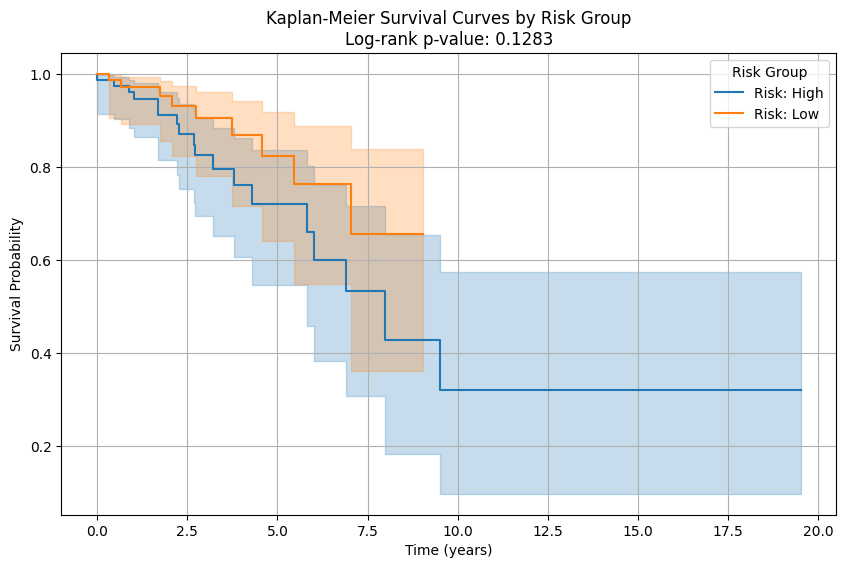

In [26]:
evaluate(net, test_dataloader, task_type="Survival", checkpoint=None, device=device, best=False, path=".", kfold="")

test

 Evalate best model


C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\458782347.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net = torch.load(checkpoint)


Lowest_Validation_Loss/Test//c-index: 0.6652286453839517
Lowest_Validation_Loss/Test//Loss: 1.638748288154602
Lowest_Validation_Loss/Test//TCGA_BRCA_c-index: 0.6652286453839517
Lowest_Validation_Loss/Test//TCGA_BRCA_Loss: 1.638748288154602
Log-rank test p-value: 0.01497660699043262


C:\Users\ricca\AppData\Local\Temp\ipykernel_22504\458782347.py:50: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['survival_predictions', 'patient_ids', 'dataset_name'], dtype='object')]

  test_df.to_hdf(f"{path}/best_test_df{df_fold_suffix}.h5", key="df", mode="w")


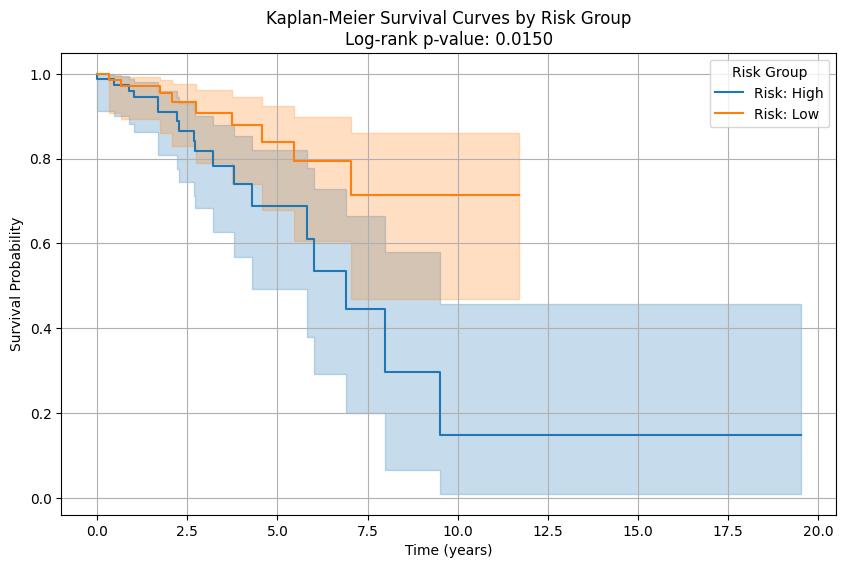

In [27]:
evaluate(net, test_dataloader, task_type="Survival", checkpoint="best_model.pt", device=device, best=True, path=".", kfold="")